# Download and save REMA data
This notebook explores three things:
1. how to select and lazily load REMA data over a) a given ice shelf, b) a given region defined by a geojson
2. how to save the data to a local zarr store (including usind a local dask cluster)
3. how to load the results from prociessing by Julian Spergel from a google bucket. 

The notebook draws heavily from here: https://github.com/ldeo-glaciology/REMAWaterRouting/blob/master/dask_drainagecatchmentmapping.ipynb

In [1]:
import json
import os
import gcsfs
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#%matplotlib widget

import geopandas as gpd
from rasterio import RasterioIOError
from tqdm.autonotebook import tqdm
import math
import shapefile
import shapely
import pandas as pd
import rioxarray

/var/folders/kl/3mt9f4qs1559xwy3mr60s7980000gp/T/ipykernel_89251/2911127816.py:12: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


## Method 1a: Load REMA tiles using Julian's code 

<Axes: >

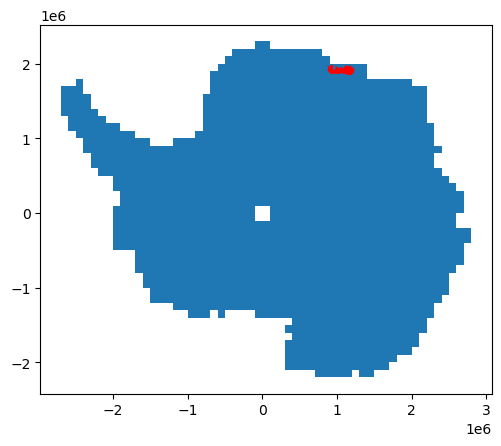

In [2]:
#read in the shapefiles of ice shelf grounding lines
IS = gpd.read_file('../../../../REMAWaterRouting/IceShelf_Antarctica_v02/IceShelf_Antarctica_v02.shp') 

#select an ice shelf, e.g. 'Amery' or 'Baudouin' ()
Baudouin = IS[IS.NAME=='Baudouin']

#read in the REMA tile index
REMA_index = gpd.read_file('../../../../REMAWaterRouting/REMA_Tile_Index/REMA_Tile_Index_Rel1_1.shp')

fig,axis = plt.subplots()
REMA_index.plot(ax=axis)
Baudouin.geometry.plot(ax=axis,color='r')

In [3]:
# find what tiles the ice shelf intersects

[minx,miny,maxx,maxy]= Baudouin.bounds.values.tolist()[0]
#[minx,miny,maxx,maxy]= DarwinGlacier.bounds

bbox = shapely.geometry.Polygon([[minx,miny],[maxx,miny],[maxx,maxy],[minx,maxy],[minx,miny]])

IS_intersection = np.argwhere(REMA_index.overlaps(bbox).tolist())

IS_tiles = REMA_index.tile[IS_intersection.flatten()]
IS_tiles

280     49_40
622     50_39
1010    49_43
1043    50_40
1095    49_39
1167    50_41
1255    49_42
1288    50_42
1315    49_41
1423    50_43
Name: tile, dtype: object

In [4]:
#extract the row and column numbers of the REMA tiles from the subsetted list of tiles, IS_tiles

row = [str.split(x,'_')[0] for x in IS_tiles.to_list()]
col = [str.split(x,'_')[1] for x in IS_tiles.to_list()]
row = np.int_(row)
col = np.int_(col)


In [5]:
#Load the REMA tiles lazily
uri_fmt = 'https://storage.googleapis.com/pangeo-pgc/8m/{i_idx:02d}_{j_idx:02d}/{i_idx:02d}_{j_idx:02d}_8m_dem_COG_LZW.tif'

chunksize = 8 * 512
rows = []
for i in tqdm(np.arange(row.max(), row.min()-1, -1)): 
    cols = []
    for j in np.arange(col.min(),col.max()+1):
        uri = uri_fmt.format(i_idx=i, j_idx=j)
        try:
            print(uri)
            dset = rioxarray.open_rasterio(uri, chunks=chunksize) 
            dset_masked = dset.where(dset > 0.0)
            cols.append(dset_masked)
            #print(uri)
        except RasterioIOError:
            print(f'failed to load tile {i},{j}')
            pass
    rows.append(cols)

  0%|          | 0/2 [00:00<?, ?it/s]

https://storage.googleapis.com/pangeo-pgc/8m/50_39/50_39_8m_dem_COG_LZW.tif
https://storage.googleapis.com/pangeo-pgc/8m/50_40/50_40_8m_dem_COG_LZW.tif
https://storage.googleapis.com/pangeo-pgc/8m/50_41/50_41_8m_dem_COG_LZW.tif
https://storage.googleapis.com/pangeo-pgc/8m/50_42/50_42_8m_dem_COG_LZW.tif
https://storage.googleapis.com/pangeo-pgc/8m/50_43/50_43_8m_dem_COG_LZW.tif


Warning 1: TIFFFetchNormalTag:ASCII value for tag "GDALNoDataValue" contains null byte in value; value incorrectly truncated during reading due to implementation limitations
Warning 1: TIFFFetchNormalTag:ASCII value for tag "GDALNoDataValue" contains null byte in value; value incorrectly truncated during reading due to implementation limitations
ERROR 1: /vsicurl/https://storage.googleapis.com/pangeo-pgc/8m/50_43/50_43_8m_dem_COG_LZW.tif:Failed to allocate memory for to read TIFF directory (0 elements of 12 bytes each)
ERROR 1: TIFFReadDirectory:Failed to read directory at offset 30222


https://storage.googleapis.com/pangeo-pgc/8m/49_39/49_39_8m_dem_COG_LZW.tif
https://storage.googleapis.com/pangeo-pgc/8m/49_40/49_40_8m_dem_COG_LZW.tif
https://storage.googleapis.com/pangeo-pgc/8m/49_41/49_41_8m_dem_COG_LZW.tif
https://storage.googleapis.com/pangeo-pgc/8m/49_42/49_42_8m_dem_COG_LZW.tif
https://storage.googleapis.com/pangeo-pgc/8m/49_43/49_43_8m_dem_COG_LZW.tif


In [6]:
dsets_rows = [xr.concat(row, 'x') for row in rows]
ds = xr.concat(dsets_rows, 'y', )

In [7]:
ds = ds.squeeze()
ds

<xarray.DataArray (y: 25000, x: 62500)>
dask.array<getitem, shape=(25000, 62500), dtype=float32, chunksize=(4096, 4096), chunktype=numpy.ndarray>
Coordinates:
    band         int64 1
  * x            (x) float64 8e+05 8e+05 8e+05 8e+05 ... 1.3e+06 1.3e+06 1.3e+06
  * y            (y) float64 2e+06 2e+06 2e+06 2e+06 ... 1.8e+06 1.8e+06 1.8e+06
    spatial_ref  int64 0
Attributes:
    AREA_OR_POINT:       Area
    OVR_RESAMPLING_ALG:  NEAREST
    _FillValue:          -9999.0
    scale_factor:        1.0
    add_offset:          0.0

Make a small geotiff consisting of just one chunk of the Boudouin dataset loaded above: 

In [9]:
from dask.distributed import Client
client = Client()  # set up local cluster on your laptop
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 8,Total memory: 24.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:62706,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 8
Started: Just now,Total memory: 24.00 GiB
Comm: tcp://127.0.0.1:62717,Total threads: 2
Dashboard: http://127.0.0.1:62721/status,Memory: 6.00 GiB
Nanny: tcp://127.0.0.1:62709,


In [8]:
# subset the data
dem_small_1 = ds.isel(x=slice(0,4095), y=slice(0,4095)).load()
# add some zeros that we will use as ocean cells later
dem_small_1[0:1,:] = 0.0 
# make a new directory for the small DEMs (if needed)
#!mkdir rema_subsets
# write the subsetted DEM to a GeoTiff
dem_small_1.rio.to_raster("rema_subsets/dem_small_1.tif")
# reload the DEM from disk
reloaded = rioxarray.open_rasterio("rema_subsets/dem_small_1.tif")
# squeeze the reloaded data
reloaded = reloaded.squeeze()
#check that the reloaded data is identical to the original
dem_small_1.identical(reloaded)


KeyboardInterrupt: 

In [10]:
# subset the data
dem_small_2 = ds.isel(x=slice(0,4095,4), y=slice(0,4095*3,4)).load()
# add some zeros that we will use as ocean cells later
dem_small_2[0,:] = 0.0 
dem_small_2[-1,:] = 0.0
dem_small_2[:,0] = 0.0
dem_small_2[:,-1] = 0.0

dem_small_2 = dem_small_2.fillna(0.0)   # fill NaNs with zeros

# make a new directory for the small DEMs (if needed)
#!mkdir rema_subsets
# write the subsetted DEM to a GeoTiff
dem_small_2.rio.to_raster("rema_subsets/dem_small_2.tif")
# reload the DEM from disk
reloaded = rioxarray.open_rasterio("rema_subsets/dem_small_2.tif")
# squeeze the reloaded data
reloaded = reloaded.squeeze()
#check that the reloaded data is identical to the original
dem_small_2.identical(reloaded)   # not sure why these are not the same, the values look the same



False

In [12]:
dem_small_2.isnull().sum().compute()  # check for NaNs

<xarray.DataArray ()>
array(0)
Coordinates:
    band         int64 1
    spatial_ref  int64 0

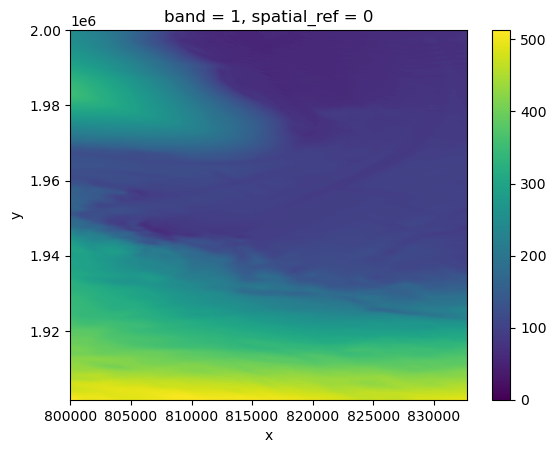

In [10]:
reloaded.plot();

In [48]:
reloaded.values[np.where((reloaded !=  dem_small_2).values)][0]

nan

In [49]:
dem_small_2.values[np.where((reloaded !=  dem_small_2).values)][0]


nan

### Try making a range of other DEMs with different sizes

In [19]:
dem_tiny = ds.isel(x=slice(0,600), y=slice(0,600)).load()
dem_tiny[0:1,:] = 0.0 
dem_tiny.rio.to_raster("rema_subsets/dem_tiny.tif")


dem_bigger = ds.isel(x=slice(0,1000), y=slice(0,1000)).load()
dem_bigger[0:1,:] = 0.0 
dem_bigger.rio.to_raster("rema_subsets/dem_bigger.tif")


dem_bigger_2 = ds.isel(x=slice(0,4000), y=slice(0,4000)).load()
dem_bigger_2[0:1,:] = 0.0 
dem_bigger_2.rio.to_raster("rema_subsets/dem_bigger_2.tif")

dem_bigger_3 = ds.isel(x=slice(0,4095,4), y=slice(0,4095*4,4)).load()
dem_bigger_3[0:1,:] = 0.0 
dem_bigger_3.rio.to_raster("rema_subsets/dem_bigger_3.tif")

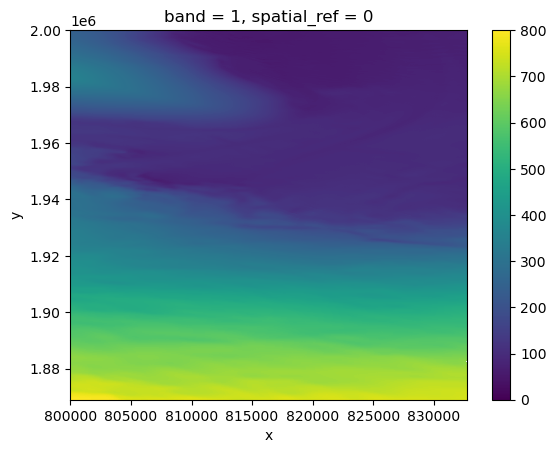

In [20]:
#tiny_reloaded = rioxarray.open_rasterio("rema_subsets/dem_tiny.tif")
dem_bigger_3.plot()

## Method 1b: Use a geojson to define the ROI and download the appropriate tiles

<Axes: >

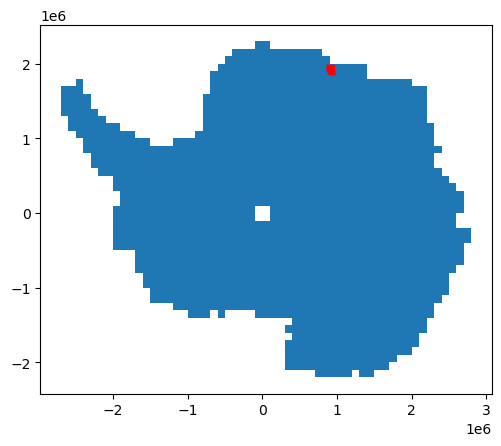

In [3]:
# get the crs by reading one file
ds = rioxarray.open_rasterio("https://storage.googleapis.com/pangeo-pgc/8m/50_39/50_39_8m_dem_COG_LZW.tif", chunks={})

#read in the shapefiles of ice shelf grounding lines
#IS = gpd.read_file('../../../../REMAWaterRouting/IceShelf_Antarctica_v02/IceShelf_Antarctica_v02.shp') 
#select an ice shelf, e.g. 'Amery' or 'Baudouin' ()
#ROI = IS[IS.NAME=='Baudouin']

# Or load a geojson file created on geojson.io
ROI = gpd.read_file('../../../ROIs/boudouin_west_1.geojson')
ROI.to_crs(ds.spatial_ref.attrs['crs_wkt'],inplace=True)

# or load geojson created in QGIS (where you can specify the crs).
#ROI = gpd.read_file('../../../ROIs/box_1.geojson')


#read in the REMA tile index
REMA_index = gpd.read_file('../../../../REMAWaterRouting/REMA_Tile_Index/REMA_Tile_Index_Rel1_1.shp')

fig,axis = plt.subplots()
REMA_index.plot(ax=axis)
ROI.geometry.plot(ax=axis,color='r')

<Axes: >

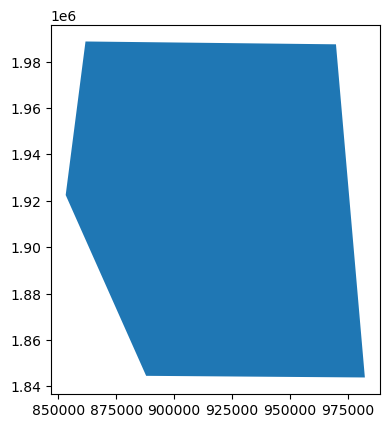

In [4]:
ROI.plot()

In [5]:
# find what tiles the ROI intersects

[minx,miny,maxx,maxy]= ROI.bounds.values.tolist()[0]

bbox = shapely.geometry.Polygon([[minx,miny],[maxx,miny],[maxx,maxy],[minx,maxy],[minx,miny]])

IS_intersection = np.argwhere(REMA_index.overlaps(bbox).tolist())

IS_tiles = REMA_index.tile[IS_intersection.flatten()]

#extract the row and column numbers of the REMA tiles from the subsetted list of tiles, IS_tiles

row = [str.split(x,'_')[0] for x in IS_tiles.to_list()]
col = [str.split(x,'_')[1] for x in IS_tiles.to_list()]
row = np.int_(row)
col = np.int_(col)

In [6]:
#Load the REMA tiles lazily
uri_fmt = 'https://storage.googleapis.com/pangeo-pgc/8m/{i_idx:02d}_{j_idx:02d}/{i_idx:02d}_{j_idx:02d}_8m_dem_COG_LZW.tif'

chunksize = 8 * 512
rows = []
for i in tqdm(np.arange(row.max(), row.min()-1, -1)): 
    cols = []
    for j in np.arange(col.min(),col.max()+1):
        uri = uri_fmt.format(i_idx=i, j_idx=j)
        try:
            print(uri)
            dset = rioxarray.open_rasterio(uri, chunks=chunksize)
            dset_masked = dset.where(dset > 0.0)
            cols.append(dset_masked)
            #print(uri)
        except RasterioIOError:
            print(f'failed to load tile {i},{j}')
            pass
    rows.append(cols)

dsets_rows = [xr.concat(row, 'x') for row in rows]
ds = xr.concat(dsets_rows, 'y', )
ds = ds.squeeze()
ds

  0%|          | 0/2 [00:00<?, ?it/s]

https://storage.googleapis.com/pangeo-pgc/8m/50_39/50_39_8m_dem_COG_LZW.tif
https://storage.googleapis.com/pangeo-pgc/8m/50_40/50_40_8m_dem_COG_LZW.tif
https://storage.googleapis.com/pangeo-pgc/8m/49_39/49_39_8m_dem_COG_LZW.tif
https://storage.googleapis.com/pangeo-pgc/8m/49_40/49_40_8m_dem_COG_LZW.tif


<xarray.DataArray (y: 25000, x: 25000)>
dask.array<getitem, shape=(25000, 25000), dtype=float32, chunksize=(4096, 4096), chunktype=numpy.ndarray>
Coordinates:
    band         int64 1
  * x            (x) float64 8e+05 8e+05 8e+05 8e+05 ... 1e+06 1e+06 1e+06 1e+06
  * y            (y) float64 2e+06 2e+06 2e+06 2e+06 ... 1.8e+06 1.8e+06 1.8e+06
    spatial_ref  int64 0
Attributes:
    AREA_OR_POINT:       Area
    OVR_RESAMPLING_ALG:  NEAREST
    _FillValue:          -9999.0
    scale_factor:        1.0
    add_offset:          0.0

## 2: writing to geotiff using while running a local cluster

In [7]:
from dask.distributed import Client

client = Client()  # set up local cluster on your laptop

client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 8,Total memory: 24.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:54373,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 8
Started: Just now,Total memory: 24.00 GiB
Comm: tcp://127.0.0.1:54385,Total threads: 2
Dashboard: http://127.0.0.1:54389/status,Memory: 6.00 GiB
Nanny: tcp://127.0.0.1:54376,


In [8]:
ds.persist()

<xarray.DataArray (y: 25000, x: 25000)>
dask.array<getitem, shape=(25000, 25000), dtype=float32, chunksize=(4096, 4096), chunktype=numpy.ndarray>
Coordinates:
    band         int64 1
  * x            (x) float64 8e+05 8e+05 8e+05 8e+05 ... 1e+06 1e+06 1e+06 1e+06
  * y            (y) float64 2e+06 2e+06 2e+06 2e+06 ... 1.8e+06 1.8e+06 1.8e+06
    spatial_ref  int64 0
Attributes:
    AREA_OR_POINT:       Area
    OVR_RESAMPLING_ALG:  NEAREST
    _FillValue:          -9999.0
    scale_factor:        1.0
    add_offset:          0.0

In [9]:
import zarr

In [26]:
ds[0:100, 0:100].to_zarr('/Users/jkingslake/Documents/science/meltwater_routing/big_data/small_test')

In [27]:
# load the data from the zarr store
ds_small = xr.open_zarr('/Users/jkingslake/Documents/science/meltwater_routing/big_data/small_test')
ds_small = ds_small.__xarray_dataarray_variable__
ds_small.name = 'elevation'
ds_small

<xarray.DataArray 'elevation' (y: 100, x: 100)>
dask.array<open_dataset-__xarray_dataarray_variable__, shape=(100, 100), dtype=float32, chunksize=(100, 100), chunktype=numpy.ndarray>
Coordinates:
    band         int64 ...
    spatial_ref  int64 ...
  * x            (x) float64 8e+05 8e+05 8e+05 ... 8.008e+05 8.008e+05 8.008e+05
  * y            (y) float64 2e+06 2e+06 2e+06 ... 1.999e+06 1.999e+06 1.999e+06
Attributes:
    AREA_OR_POINT:       Area
    OVR_RESAMPLING_ALG:  NEAREST

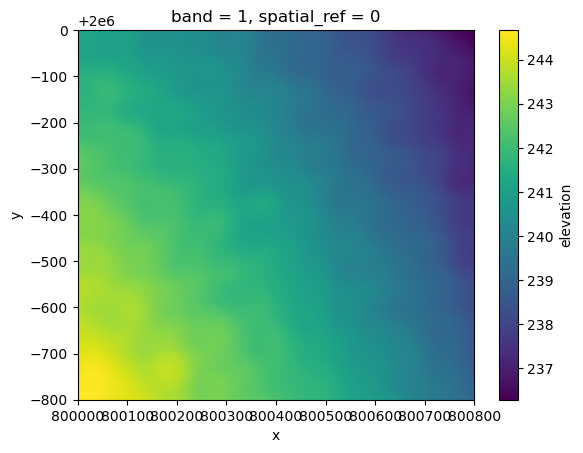

In [28]:
# plot the data to check that it was saved and then loaded correctly.
ds_small.plot()


Write a reduced version of the REMA data to a geotiff file.

In [35]:
ds.isel(x=slice(0,25000,10),y=slice(0,25000,10)).rio.to_raster("/Users/jkingslake/Documents/science/meltwater_routing/big_data/boudouin_west_1.tif")

### Try writing to zarr
When trying to write to zarr (with `ds.to_zarr('/Users/jkingslake/Documents/science/meltwater_routing/big_data/boudouin_west_1')`) we find that this fails because the chunk sizes are not uniform. This is because we have concatenated several tiles together, each of which has the last chunk in each dimension a different size than the other chunks. 

The following is an attempt to rechunk to uniform chunk sizes. It fails with `OSError: [Errno 22] Invalid argument`

In [32]:
ds_rechunked = ds.chunk({'x': 4096, 'y': 4096}).compute()

OSError: [Errno 22] Invalid argument

Next let's try rechunking a smaller version of the data


In [36]:
ds_rechunked_smaller = ds.isel(x=slice(0,25000,),y=slice(0,25000,10)).chunk({'x': 4096, 'y': 4096}).compute()

In [38]:
ds_rechunked_smaller.to_zarr('/Users/jkingslake/Documents/science/meltwater_routing/big_data/boudouin_west_1_smaller')

In [39]:
# reload
ds_rechunked_smaller_reloaded = xr.open_zarr('/Users/jkingslake/Documents/science/meltwater_routing/big_data/boudouin_west_1_smaller')
ds_rechunked_smaller_reloaded = ds_rechunked_smaller_reloaded.__xarray_dataarray_variable__
ds_rechunked_smaller_reloaded.name = 'elevation'
ds_rechunked_smaller_reloaded

<xarray.DataArray 'elevation' (y: 2500, x: 2500)>
dask.array<open_dataset-__xarray_dataarray_variable__, shape=(2500, 2500), dtype=float32, chunksize=(313, 625), chunktype=numpy.ndarray>
Coordinates:
    band         int64 ...
    spatial_ref  int64 ...
  * x            (x) float64 8e+05 8.001e+05 8.002e+05 ... 9.998e+05 9.999e+05
  * y            (y) float64 2e+06 2e+06 2e+06 2e+06 ... 1.8e+06 1.8e+06 1.8e+06
Attributes:
    AREA_OR_POINT:       Area
    OVR_RESAMPLING_ALG:  NEAREST

In [40]:
ds_rechunked_smaller = ds.isel(x=slice(0,25000,4),y=slice(0,25000,4)).chunk({'x': 4096, 'y': 4096}).compute()
ds_rechunked_smaller.to_zarr('/Users/jkingslake/Documents/science/meltwater_routing/big_data/boudouin_west_1_bigger')

In [41]:
ds_rechunked_smaller

<xarray.DataArray (y: 6250, x: 6250)>
array([[ 241.17886,  241.1166 ,  241.03474, ...,        nan,        nan,
               nan],
       [ 241.14444,  241.08432,  241.00006, ...,        nan,        nan,
               nan],
       [ 241.29431,  241.28967,  241.20699, ...,        nan,        nan,
               nan],
       ...,
       [1377.2773 , 1377.0137 , 1376.8381 , ...,  969.14154,  969.14886,
         969.2848 ],
       [1377.5549 , 1377.324  , 1377.1128 , ...,  969.57025,  969.4849 ,
         969.47614],
       [1377.9813 , 1377.8157 , 1377.4368 , ...,  969.8613 ,  969.6397 ,
         969.62537]], dtype=float32)
Coordinates:
    band         int64 1
  * x            (x) float64 8e+05 8e+05 8.001e+05 ... 9.999e+05 9.999e+05 1e+06
  * y            (y) float64 2e+06 2e+06 2e+06 2e+06 ... 1.8e+06 1.8e+06 1.8e+06
    spatial_ref  int64 0
Attributes:
    AREA_OR_POINT:       Area
    OVR_RESAMPLING_ALG:  NEAREST
    _FillValue:          -9999.0
    scale_factor:        1.0
    add_offset:          0.0

## 3: Downloading the processed data
Julian put 'processed' data in the google bucket. But this appearrs to just be the computed drainage basins, not the desriped DEMs. The cell below load these. One other issue is that the processed data is rotated 90 degrees from the original data. 

In [ ]:
ice_shelf = 'Amery'
with open('/Users/jkingslake/Documents/misc/ldeo-glaciology-bc97b12df06b.json') as token_file:
    token = json.load(token_file)
gcs = gcsfs.GCSFileSystem(token=token)
mapper = gcs.get_mapper(str('gs://ldeo-glaciology/REMA/processed/'+ice_shelf))


In [ ]:
processed = xr.open_zarr(mapper, consolidated=False)

In [ ]:
processed

<xarray.Dataset>
Dimensions:      (y: 18750, x: 6250)
Coordinates:
  * x            (x) float64 8e+05 8e+05 7.999e+05 ... 6.001e+05 6e+05 6e+05
  * y            (y) float64 1.6e+06 1.6e+06 1.6e+06 ... 2.2e+06 2.2e+06 2.2e+06
Data variables:
    DB_filled    (y, x) float64 dask.array<chunksize=(586, 391), meta=np.ndarray>
    DB_unfilled  (y, x) float64 dask.array<chunksize=(586, 391), meta=np.ndarray>
    P_all        (y, x) float64 dask.array<chunksize=(586, 391), meta=np.ndarray>

In [ ]:
(processed.x[1]-processed.x[0]).values, (processed.y[1]-processed.y[0]).values

(array(-32.), array(32.))

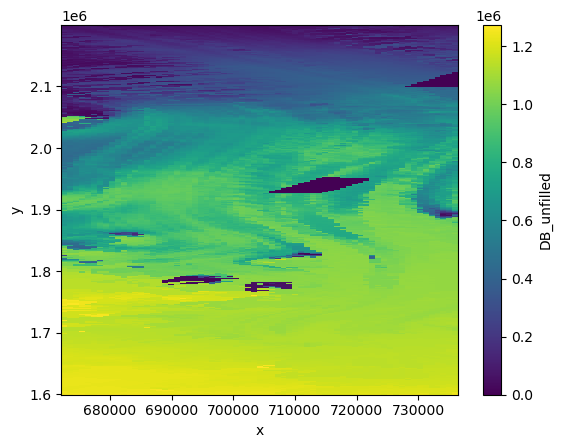

In [ ]:
# plot a low resolutio nsubset of the unfilled drainage basins
processed.isel(x=slice(2000,4000,30),y=slice(0,None,30)).DB_unfilled.plot() 

6.008


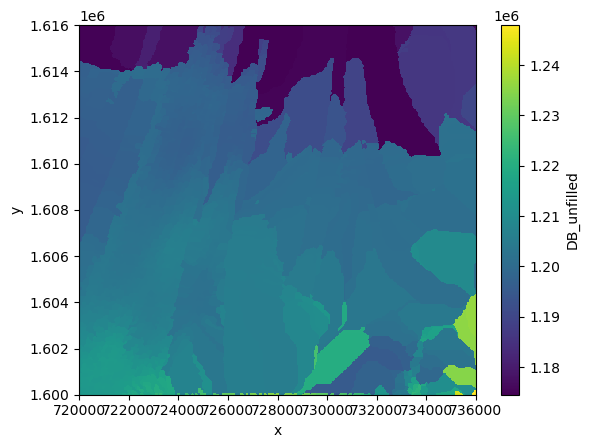

In [ ]:
# plot just an much smaller subset at the full resolution
s = processed.isel(x=slice(2000,2500),y=slice(0,500))
print(s.nbytes/1e6)
s.DB_unfilled.plot()
